In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print("Libs Imported")

Libs Imported


# 1) First Look

In [2]:
df = pd.read_csv("data/16-diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [8]:
cols = ["Insulin", "SkinThickness", "Pregnancies", "Glucose", "BloodPressure", "BMI"]
total_rows = len(df)

zero_stats = pd.DataFrame({
    "Zero Count": (df[cols] == 0).sum(),
    "Total Count": df[cols].count(),
})

zero_stats["Zero Ratio (%)"] = (zero_stats["Zero Count"] / total_rows * 100).round(2)
print(zero_stats)

               Zero Count  Total Count  Zero Ratio (%)
Insulin               374          768           48.70
SkinThickness         227          768           29.56
Pregnancies           111          768           14.45
Glucose                 5          768            0.65
BloodPressure          35          768            4.56
BMI                    11          768            1.43


# 2) Missing Values

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def simple_imputation_method(df):
    """
    Basit medyan ile doldurma - karşılaştırma için
    """
    df_simple = df.copy()
    
    # Sıfır değerleri NaN yap
    columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin']
    for col in columns_to_replace:
        df_simple[col] = df_simple[col].replace(0, np.nan)
    
    # Hepsini basit medyan ile doldur
    for col in columns_to_replace:
        median_val = df_simple[col].median()
        df_simple[col] = df_simple[col].fillna(median_val)
    
    print(f"Basit Medyan - Insulin median: {df_simple['Insulin'].median():.1f}")
    return df_simple

def group_median_insulin_imputation(df):
    """
    Medical knowledge ile grup medyanı kullanarak insulin doldurma
    """
    print("=== GROUP MEDIAN INSULIN IMPUTATION ===")
    df_filled = df.copy()
    
    # Sıfır değerleri NaN yap - BMI DE DAHIL!
    columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in columns_to_replace:
        df_filled[col] = df_filled[col].replace(0, np.nan)
    
    # Önce diğer değişkenleri doldur (insulin için gruplamada kullanmak için)
    print("Filling other variables first...")
    
    # Yaş grupları (BMI için de kullanılacak)
    df_filled['Age_Group'] = pd.cut(df_filled['Age'], 
                                   bins=[0, 30, 45, 100], 
                                   labels=['Young', 'Middle', 'Senior'])
    
    # 1. BMI - yaş gruplarına göre (önce BMI'yı doldur, diğerleri için gerekli)
    print("Filling BMI...")
    df_filled['BMI'] = df_filled.groupby('Age_Group', observed=True)['BMI'].transform(
        lambda x: x.fillna(x.median())
    )
    df_filled['BMI'] = df_filled['BMI'].fillna(df_filled['BMI'].median())
    
    # 2. GLUCOSE - yaş gruplarına göre
    print("Filling Glucose...")
    df_filled['Glucose'] = df_filled.groupby('Age_Group', observed=True)['Glucose'].transform(
        lambda x: x.fillna(x.median())
    )
    df_filled['Glucose'] = df_filled['Glucose'].fillna(df_filled['Glucose'].median())
    
    # 3. BLOOD PRESSURE - yaş gruplarına göre
    print("Filling BloodPressure...")
    df_filled['BloodPressure'] = df_filled.groupby('Age_Group', observed=True)['BloodPressure'].transform(
        lambda x: x.fillna(x.median())
    )
    df_filled['BloodPressure'] = df_filled['BloodPressure'].fillna(df_filled['BloodPressure'].median())
    
    # 4. SKIN THICKNESS - BMI gruplarına göre (şimdi BMI temiz)
    print("Filling SkinThickness...")
    df_filled['BMI_Group'] = pd.cut(df_filled['BMI'], 
                                   bins=[0, 25, 30, 100], 
                                   labels=['Normal', 'Overweight', 'Obese'])
    
    df_filled['SkinThickness'] = df_filled.groupby('BMI_Group', observed=True)['SkinThickness'].transform(
        lambda x: x.fillna(x.median())
    )
    df_filled['SkinThickness'] = df_filled['SkinThickness'].fillna(df_filled['SkinThickness'].median())
    
    # ŞİMDİ INSULIN İÇİN MEDICAL KNOWLEDGE GRUPLAMA
    print("Creating medical groups for insulin...")
    
    # 1. Glucose Risk Categories (en önemli factor)
    df_filled['Glucose_Risk'] = pd.cut(df_filled['Glucose'], 
                                      bins=[0, 100, 140, 200], 
                                      labels=['Normal', 'Prediabetic', 'Diabetic'])
    
    # 2. BMI Risk Categories  
    df_filled['BMI_Risk'] = pd.cut(df_filled['BMI'], 
                                  bins=[0, 25, 30, 100], 
                                  labels=['Normal', 'Overweight', 'Obese'])
    
    # 3. Age Risk Categories
    df_filled['Age_Risk'] = pd.cut(df_filled['Age'], 
                                  bins=[0, 40, 100], 
                                  labels=['Young', 'Mature'])
    
    # 4. Multi-dimensional grouping için medical combinations
    print("Insulin group medians by medical categories:")
    
    # Önce mevcut insulin değerleri ile group statistics'leri hesapla
    insulin_present = df_filled[df_filled['Insulin'].notna()].copy()
    
    # Primary grouping: Glucose + BMI (insulin'un en güçlü predictors)
    group_stats = insulin_present.groupby(['Glucose_Risk', 'BMI_Risk'], observed=True)['Insulin'].agg(['median', 'count']).reset_index()
    print("Glucose + BMI Group Medians:")
    print(group_stats)
    
    # INSULIN DOLDURMA STRATEJİSİ
    print("\nFilling insulin values...")
    
    # Strateji 1: Glucose + BMI gruplarına göre
    df_filled['Insulin'] = df_filled.groupby(['Glucose_Risk', 'BMI_Risk'], observed=True)['Insulin'].transform(
        lambda x: x.fillna(x.median()) if x.notna().sum() >= 3 else x
    )
    
    # Strateji 2: Hala boş olanlar için sadece Glucose gruplarına göre
    df_filled['Insulin'] = df_filled.groupby('Glucose_Risk', observed=True)['Insulin'].transform(
        lambda x: x.fillna(x.median()) if x.notna().sum() >= 5 else x
    )
    
    # Strateji 3: Hala boş olanlar için genel medyan
    overall_median = insulin_present['Insulin'].median()
    df_filled['Insulin'] = df_filled['Insulin'].fillna(overall_median)
    
    # Pregnancies simple approach
    if df_filled['Pregnancies'].isna().any():
        pregnancies_median = df_filled.groupby('Age_Group', observed=True)['Pregnancies'].transform(
            lambda x: x.fillna(x.median())
        )
        df_filled['Pregnancies'] = pregnancies_median.fillna(df_filled['Pregnancies'].median())
    
    # Yardımcı sütunları kaldır
    cols_to_drop = ['Age_Group', 'BMI_Group', 'Glucose_Risk', 'BMI_Risk', 'Age_Risk']
    df_filled = df_filled.drop([col for col in cols_to_drop if col in df_filled.columns], axis=1)
    
    print(f"\nGroup Median - Final insulin median: {df_filled['Insulin'].median():.1f}")
    print(f"Insulin range: {df_filled['Insulin'].min():.1f} - {df_filled['Insulin'].max():.1f}")
    print(f"BMI range: {df_filled['BMI'].min():.1f} - {df_filled['BMI'].max():.1f}")
    
    return df_filled

def compare_imputation_methods(df):
    """
    Farklı imputation yöntemlerini karşılaştır
    """
    print("=== IMPUTATION METHODS COMPARISON ===\n")
    
    # Method 1: Simple median
    df_simple = simple_imputation_method(df)
    
    # Method 2: Group median (medical knowledge)
    df_group = group_median_insulin_imputation(df)
    
    # Method 3: Complex ML (şimdilik skip)
    # df_complex = complex_ml_method(df)  # Şimdilik skip
    
    return df_simple, df_group

def evaluate_imputation_quality(df_simple, df_group, df_original):
    """
    Imputation kalitesini değerlendir - outcome prediction ile
    """
    print("=== EVALUATING IMPUTATION QUALITY ===")
    
    results = {}
    
    for name, df_imp in [('Simple Median', df_simple), ('Group Median', df_group)]:
        print(f"\n--- {name} Method ---")
        
        # Outcome prediction ile test et
        X = df_imp.drop('Outcome', axis=1)
        y = df_imp['Outcome']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Simple Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Outcome Prediction Accuracy: {accuracy:.3f}")
        
        # Insulin dağılım istatistikleri
        print(f"Insulin Stats:")
        print(f"  Mean: {df_imp['Insulin'].mean():.1f}")
        print(f"  Median: {df_imp['Insulin'].median():.1f}")
        print(f"  Std: {df_imp['Insulin'].std():.1f}")
        print(f"  Range: {df_imp['Insulin'].min():.1f} - {df_imp['Insulin'].max():.1f}")
        
        results[name] = {
            'accuracy': accuracy,
            'insulin_mean': df_imp['Insulin'].mean(),
            'insulin_median': df_imp['Insulin'].median(),
            'insulin_std': df_imp['Insulin'].std()
        }
    
    return results

def plot_imputation_comparison(df_original, df_simple, df_group):
    """
    Imputation yöntemlerini görselleştir
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original insulin distribution (non-zero values)
    original_insulin = df_original[df_original['Insulin'] > 0]['Insulin']
    
    # 1. Insulin distributions comparison
    ax1 = axes[0, 0]
    ax1.hist(original_insulin, alpha=0.7, bins=30, label='Original (non-zero)', color='blue')
    ax1.hist(df_simple['Insulin'], alpha=0.5, bins=30, label='Simple Median', color='red')
    ax1.hist(df_group['Insulin'], alpha=0.5, bins=30, label='Group Median', color='green')
    ax1.set_title('Insulin Distribution Comparison')
    ax1.legend()
    ax1.set_xlabel('Insulin')
    ax1.set_ylabel('Frequency')
    
    # 2. Box plots
    ax2 = axes[0, 1]
    data_to_plot = [original_insulin, df_simple['Insulin'], df_group['Insulin']]
    ax2.boxplot(data_to_plot, labels=['Original', 'Simple', 'Group'])
    ax2.set_title('Insulin Distribution Box Plots')
    ax2.set_ylabel('Insulin')
    
    # 3. Glucose vs Insulin - Simple
    ax3 = axes[1, 0]
    ax3.scatter(df_simple['Glucose'], df_simple['Insulin'], alpha=0.6, color='red')
    ax3.set_title('Glucose vs Insulin - Simple Median')
    ax3.set_xlabel('Glucose')
    ax3.set_ylabel('Insulin')
    
    # 4. Glucose vs Insulin - Group
    ax4 = axes[1, 1]
    ax4.scatter(df_group['Glucose'], df_group['Insulin'], alpha=0.6, color='green')
    ax4.set_title('Glucose vs Insulin - Group Median')
    ax4.set_xlabel('Glucose')
    ax4.set_ylabel('Insulin')
    
    plt.tight_layout()
    plt.show()

# Main comparison function
def run_imputation_comparison(df):
    """
    Tüm imputation yöntemlerini karşılaştır
    """
    # Compare methods
    df_simple, df_group = compare_imputation_methods(df)
    
    # Evaluate quality
    results = evaluate_imputation_quality(df_simple, df_group, df)
    
    # Plot comparison
    plot_imputation_comparison(df, df_simple, df_group)
    
    print("\n=== FINAL COMPARISON ===")
    for method, metrics in results.items():
        print(f"{method}: Accuracy = {metrics['accuracy']:.3f}")
    
    # Recommendation
    best_method = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\nRecommendation: {best_method} method performs best!")
    
    return df_simple, df_group, results

print("Group Median Insulin Imputation ready!")
print("Usage: df_simple, df_group, results = run_imputation_comparison(df)")

Group Median Insulin Imputation ready!
Usage: df_simple, df_group, results = run_imputation_comparison(df)


=== IMPUTATION METHODS COMPARISON ===

Basit Medyan - Insulin median: 125.0
=== GROUP MEDIAN INSULIN IMPUTATION ===
Filling other variables first...
Filling BMI...
Filling Glucose...
Filling BloodPressure...
Filling SkinThickness...
Creating medical groups for insulin...
Insulin group medians by medical categories:
Glucose + BMI Group Medians:
  Glucose_Risk    BMI_Risk  median  count
0       Normal      Normal    55.0     23
1       Normal  Overweight    64.0     29
2       Normal       Obese    76.0     64
3  Prediabetic      Normal   115.0     20
4  Prediabetic  Overweight   118.0     42
5  Prediabetic       Obese   145.0    111
6     Diabetic      Normal   110.0      3
7     Diabetic  Overweight   140.0     17
8     Diabetic       Obese   231.0     85

Filling insulin values...

Group Median - Final insulin median: 125.5
Insulin range: 14.0 - 846.0
BMI range: 18.2 - 67.1
=== EVALUATING IMPUTATION QUALITY ===

--- Simple Median Method ---
Outcome Prediction Accuracy: 0.734
Insulin S

C:\Users\Batuhan\AppData\Local\Temp\ipykernel_18384\3308020431.py:224: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_to_plot, labels=['Original', 'Simple', 'Group'])


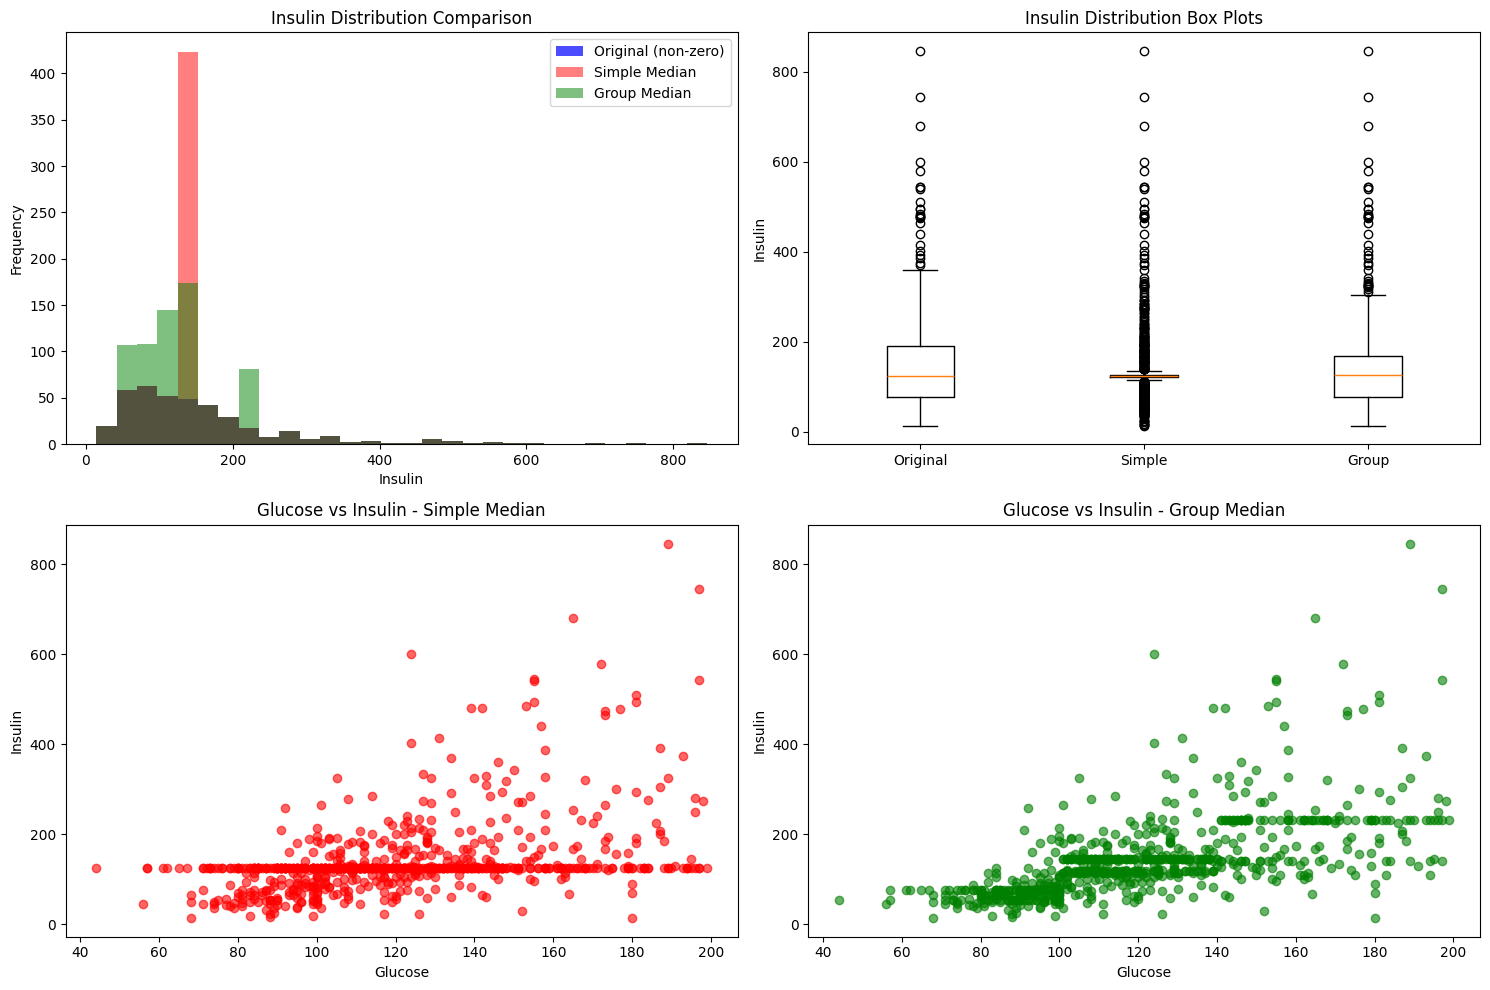


=== FINAL COMPARISON ===
Simple Median: Accuracy = 0.734
Group Median: Accuracy = 0.734

Recommendation: Simple Median method performs best!


In [10]:
# Eksik değerleri doldur - ASIL İŞ BURADA BAŞLIYOR
df_simple, df_group, results = run_imputation_comparison(df)

# 3) Modeling

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def create_final_features(df):
    """
    Final model için basit feature engineering
    """
    df_features = df.copy()
    
    # Medical knowledge features (basit olanlar)
    df_features['BMI_Category'] = pd.cut(df_features['BMI'], 
                                        bins=[0, 25, 30, 100], 
                                        labels=[0, 1, 2])
    
    df_features['Glucose_Category'] = pd.cut(df_features['Glucose'], 
                                           bins=[0, 100, 140, 200], 
                                           labels=[0, 1, 2])
    
    df_features['Age_Category'] = pd.cut(df_features['Age'], 
                                        bins=[0, 30, 45, 100], 
                                        labels=[0, 1, 2])
    
    # Simple interactions (medical sense)
    df_features['Glucose_BMI'] = df_features['Glucose'] * df_features['BMI'] / 1000
    df_features['Age_BMI'] = df_features['Age'] * df_features['BMI'] / 100
    
    # Categorical to numeric
    df_features['BMI_Category'] = df_features['BMI_Category'].astype(int)
    df_features['Glucose_Category'] = df_features['Glucose_Category'].astype(int)
    df_features['Age_Category'] = df_features['Age_Category'].astype(int)
    
    return df_features

def define_models():
    """
    Model tanımları - basit ama etkili parameterler
    """
    models = {
        # 1. AdaBoost (required)
        'AdaBoost': {
            'model': AdaBoostClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150],
                'learning_rate': [0.5, 1.0, 1.5]
            }
        },
        
        # 2. Gradient Boosting (boost algorithm 1)
        'GradientBoost': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150],
                'learning_rate': [0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5]
            }
        },
        
        # 3. XGBoost (boost algorithm 2)
        'XGBoost': {
            'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'params': {
                'n_estimators': [50, 100, 150],
                'learning_rate': [0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5]
            }
        },
        
        # 4. Logistic Regression (suitable regression model)
        'LogisticRegression': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'params': {
                'C': [0.1, 1.0, 10.0],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }
        },
        
        # 5. Random Forest (bonus - for comparison)
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150],
                'max_depth': [5, 10, 15],
                'min_samples_split': [2, 5]
            }
        }
    }
    
    return models

def quick_gridsearch(X_train, y_train, models):
    """
    Hızlı GridSearch - abartı olmayan parameterler
    """
    print("=== QUICK GRIDSEARCH (3-fold CV) ===")
    best_models = {}
    results = {}
    
    for name, model_info in models.items():
        print(f"\n🔄 Training {name}...")
        
        # 3-fold CV for speed
        grid_search = GridSearchCV(
            estimator=model_info['model'],
            param_grid=model_info['params'],
            cv=3,  # Fast CV
            scoring='accuracy',
            n_jobs=-1,  # Use all cores
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        best_models[name] = grid_search.best_estimator_
        results[name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        
        print(f"✅ {name} - CV Score: {grid_search.best_score_:.3f}")
        print(f"   Best params: {grid_search.best_params_}")
    
    return best_models, results

def evaluate_models(best_models, X_train, X_test, y_train, y_test):
    """
    Model performanslarını değerlendir
    """
    print("\n=== MODEL EVALUATION ===")
    
    evaluation_results = {}
    predictions = {}
    
    for name, model in best_models.items():
        print(f"\n--- {name} ---")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        evaluation_results[name] = {
            'accuracy': accuracy,
            'auc': auc_score,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        predictions[name] = y_pred
        
        print(f"Accuracy: {accuracy:.3f}")
        if auc_score:
            print(f"AUC: {auc_score:.3f}")
    
    return evaluation_results, predictions

def plot_model_comparison(evaluation_results):
    """
    Model performanslarını görselleştir
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Accuracy comparison
    ax1 = axes[0]
    models = list(evaluation_results.keys())
    accuracies = [evaluation_results[model]['accuracy'] for model in models]
    
    bars = ax1.bar(models, accuracies, color=['red', 'blue', 'green', 'orange', 'purple'])
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0.7, 0.8)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    
    # 2. AUC comparison
    ax2 = axes[1]
    auc_scores = [evaluation_results[model]['auc'] for model in models if evaluation_results[model]['auc']]
    auc_models = [model for model in models if evaluation_results[model]['auc']]
    
    if auc_scores:
        bars2 = ax2.bar(auc_models, auc_scores, color=['red', 'blue', 'green', 'orange', 'purple'][:len(auc_scores)])
        ax2.set_title('Model AUC Comparison')
        ax2.set_ylabel('AUC Score')
        ax2.set_ylim(0.7, 0.9)
        
        # Add value labels
        for bar, auc in zip(bars2, auc_scores):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{auc:.3f}', ha='center', va='bottom')
        
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def get_feature_importance(best_models, feature_names):
    """
    Feature importance'ları göster
    """
    print("\n=== FEATURE IMPORTANCE ===")
    
    for name, model in best_models.items():
        if hasattr(model, 'feature_importances_'):
            print(f"\n--- {name} Feature Importance ---")
            
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(importance_df.head(8))

def diabetes_prediction_pipeline(df_clean):
    """
    Complete diabetes prediction pipeline
    """
    print("=== DIABETES PREDICTION PIPELINE ===")
    print(f"Dataset shape: {df_clean.shape}")
    
    # 1. Feature Engineering
    print("\n1. Creating features...")
    df_features = create_final_features(df_clean)
    
    # 2. Prepare data
    X = df_features.drop('Outcome', axis=1)
    y = df_features['Outcome']
    
    print(f"Features: {X.columns.tolist()}")
    print(f"Class distribution: {y.value_counts().to_dict()}")
    
    # 3. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 4. Scale features (for LogisticRegression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 5. Define models
    models = define_models()
    
    # 6. GridSearch
    print("\n2. Running GridSearch...")
    best_models, grid_results = quick_gridsearch(X_train, y_train, models)
    
    # For LogisticRegression, use scaled data
    if 'LogisticRegression' in best_models:
        lr_model = best_models['LogisticRegression']
        lr_model.fit(X_train_scaled, y_train)
        best_models['LogisticRegression'] = lr_model
    
    # 7. Evaluate models
    print("\n3. Evaluating models...")
    # Use scaled data for LogisticRegression evaluation
    evaluation_results, predictions = evaluate_models(
        {k: v for k, v in best_models.items() if k != 'LogisticRegression'}, 
        X_train, X_test, y_train, y_test
    )
    
    # Separate evaluation for LogisticRegression
    if 'LogisticRegression' in best_models:
        lr_model = best_models['LogisticRegression']
        lr_pred = lr_model.predict(X_test_scaled)
        lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
        
        evaluation_results['LogisticRegression'] = {
            'accuracy': accuracy_score(y_test, lr_pred),
            'auc': roc_auc_score(y_test, lr_pred_proba),
            'predictions': lr_pred,
            'probabilities': lr_pred_proba
        }
        predictions['LogisticRegression'] = lr_pred
    
    # 8. Plot results
    plot_model_comparison(evaluation_results)
    
    # 9. Feature importance
    get_feature_importance(best_models, X.columns.tolist())
    
    # 10. Final recommendation
    print("\n=== FINAL RESULTS ===")
    for model, results in evaluation_results.items():
        print(f"{model}: Accuracy = {results['accuracy']:.3f}, AUC = {results['auc']:.3f}")
    
    best_model_name = max(evaluation_results.keys(), 
                         key=lambda x: evaluation_results[x]['accuracy'])
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"Final Accuracy: {evaluation_results[best_model_name]['accuracy']:.3f}")
    print(f"Final AUC: {evaluation_results[best_model_name]['auc']:.3f}")
    
    return best_models, evaluation_results, predictions, scaler

# Usage
print("Diabetes Prediction Pipeline Ready!")
print("Usage: best_models, results, predictions, scaler = diabetes_prediction_pipeline(df_group)")

Diabetes Prediction Pipeline Ready!
Usage: best_models, results, predictions, scaler = diabetes_prediction_pipeline(df_group)


=== DIABETES PREDICTION PIPELINE ===
Dataset shape: (768, 9)

1. Creating features...
Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'BMI_Category', 'Glucose_Category', 'Age_Category', 'Glucose_BMI', 'Age_BMI']
Class distribution: {0: 500, 1: 268}

2. Running GridSearch...
=== QUICK GRIDSEARCH (3-fold CV) ===

🔄 Training AdaBoost...
✅ AdaBoost - CV Score: 0.762
   Best params: {'learning_rate': 0.5, 'n_estimators': 50}

🔄 Training GradientBoost...
✅ GradientBoost - CV Score: 0.756
   Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

🔄 Training XGBoost...
✅ XGBoost - CV Score: 0.757
   Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

🔄 Training LogisticRegression...
✅ LogisticRegression - CV Score: 0.777
   Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

🔄 Training RandomForest...
✅ RandomForest - CV Score: 0.779
   Best params: {'max_depth': 5

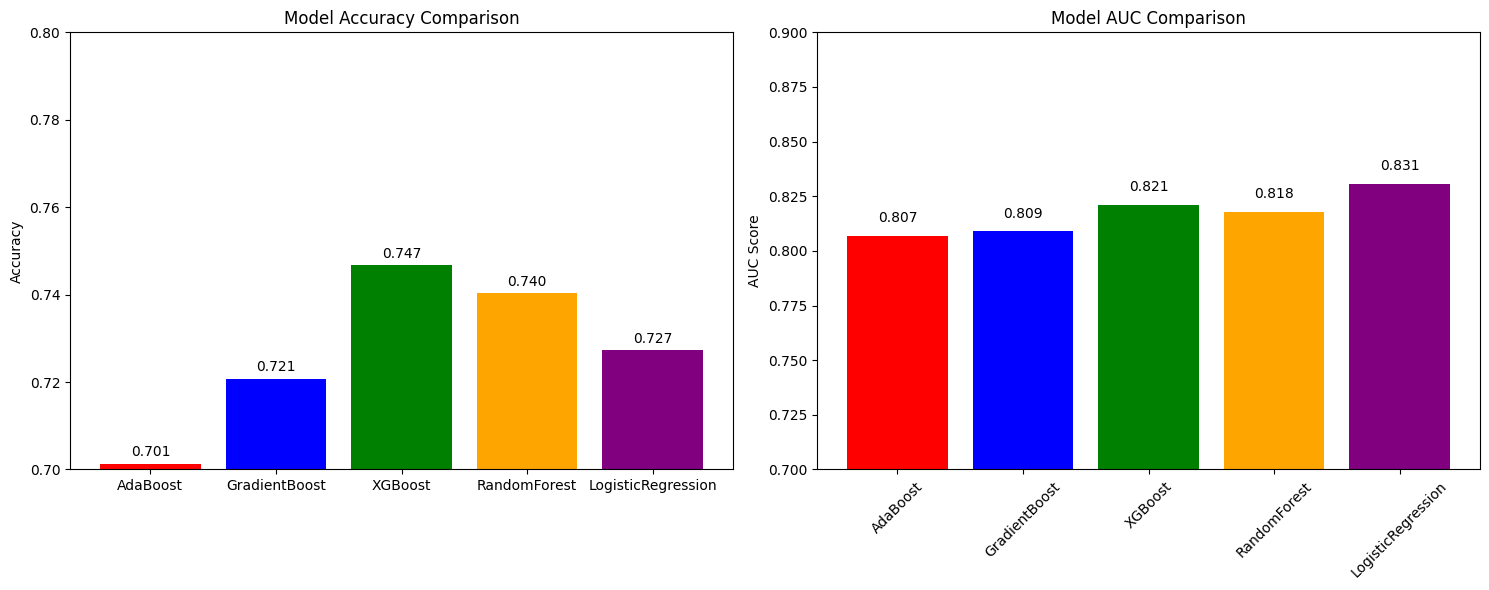


=== FEATURE IMPORTANCE ===

--- AdaBoost Feature Importance ---
                     feature  importance
11               Glucose_BMI    0.607410
12                   Age_BMI    0.138630
1                    Glucose    0.078085
4                    Insulin    0.070899
0                Pregnancies    0.043351
7                        Age    0.031486
6   DiabetesPedigreeFunction    0.030139
2              BloodPressure    0.000000

--- GradientBoost Feature Importance ---
                     feature  importance
11               Glucose_BMI    0.497645
12                   Age_BMI    0.098864
1                    Glucose    0.098426
4                    Insulin    0.078290
6   DiabetesPedigreeFunction    0.074185
7                        Age    0.050865
0                Pregnancies    0.046068
5                        BMI    0.035150

--- XGBoost Feature Importance ---
                     feature  importance
11               Glucose_BMI    0.375095
1                    Glucose    0.117

In [14]:
# Final modeling pipeline
best_models, results, predictions, scaler = diabetes_prediction_pipeline(df_group)

In [17]:
df_final = df_group.copy()

# 4) Better Approaches

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def create_medical_features(df):
    """
    Medical domain knowledge - akıllıca feature engineering
    """
    df_features = df.copy()
    
    # 1. BASIC CATEGORICALS (3 bins - simple)
    df_features['BMI_Category'] = pd.cut(df_features['BMI'], 
                                        bins=[0, 25, 30, 100], 
                                        labels=[0, 1, 2], include_lowest=True)
    
    df_features['Glucose_Category'] = pd.cut(df_features['Glucose'], 
                                           bins=[0, 100, 140, 300], 
                                           labels=[0, 1, 2], include_lowest=True)
    
    df_features['Age_Category'] = pd.cut(df_features['Age'], 
                                        bins=[0, 35, 50, 100], 
                                        labels=[0, 1, 2], include_lowest=True)
    
    # 2. MEDICAL INDICES (evidence-based)
    
    # HOMA-IR Index (Homeostatic Model Assessment - Insulin Resistance)
    # Clinical standard for insulin resistance
    df_features['HOMA_IR'] = (df_features['Glucose'] * df_features['Insulin']) / 405
    
    # Body Mass Index Risk (BMI^2 for non-linear relationship)
    df_features['BMI_Squared'] = df_features['BMI'] ** 2
    
    # Age-adjusted BMI (obesity impact increases with age)
    df_features['Age_BMI_Risk'] = df_features['Age'] * df_features['BMI'] / 1000
    
    # Glucose load (glucose level relative to normal)
    df_features['Glucose_Load'] = df_features['Glucose'] / 100  # Normalized glucose
    
    # 3. METABOLIC SYNDROME INDICATORS
    
    # Metabolic syndrome risk count (0-4 risk factors)
    metabolic_risk = 0
    metabolic_risk += (df_features['Glucose'] >= 100).astype(int)      # Fasting glucose ≥100
    metabolic_risk += (df_features['BMI'] >= 30).astype(int)           # Obesity
    metabolic_risk += (df_features['BloodPressure'] >= 130).astype(int) # Hypertension  
    metabolic_risk += (df_features['Age'] >= 45).astype(int)           # Age risk
    
    df_features['Metabolic_Risk_Count'] = metabolic_risk
    
    # High-risk metabolic profile (binary)
    df_features['High_Metabolic_Risk'] = (metabolic_risk >= 3).astype(int)
    
    # 4. PREGNANCY & GENETIC RISK
    
    # Pregnancy diabetes risk (gestational diabetes indicator)
    df_features['Pregnancy_Risk'] = (df_features['Pregnancies'] >= 2).astype(int)
    
    # Genetic risk amplifier
    df_features['Genetic_Risk'] = df_features['DiabetesPedigreeFunction'] * 10  # Scale up for impact
    
    # Combined genetic-metabolic risk
    df_features['Genetic_Metabolic'] = df_features['DiabetesPedigreeFunction'] * df_features['Glucose'] / 100
    
    # 5. CONVERT CATEGORICALS TO NUMERIC (safe conversion)
    categorical_cols = ['BMI_Category', 'Glucose_Category', 'Age_Category']
    for col in categorical_cols:
        df_features[col] = pd.to_numeric(df_features[col], errors='coerce').fillna(1).astype(int)
    
    return df_features

def improved_pipeline_with_smote(df, model_type='XGBoost'):
    """
    Improved pipeline with SMOTE and proper data leakage prevention
    """
    print(f"=== IMPROVED PIPELINE - {model_type} ===")
    print(f"Original dataset shape: {df.shape}")
    
    # 1. FEATURE ENGINEERING (before any split)
    print("\n1. Creating medical features...")
    df_features = create_medical_features(df)
    
    # 2. PREPARE DATA
    X = df_features.drop('Outcome', axis=1)
    y = df_features['Outcome']
    
    print(f"Feature count: {X.shape[1]}")
    print(f"Original class distribution: {dict(y.value_counts())}")
    print(f"Original class ratio: {y.mean():.3f} (diabetes rate)")
    
    # 3. TRAIN-TEST SPLIT (before SMOTE - prevent data leakage)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # 4. APPLY SMOTE (only on training data)
    print("\n2. Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"After SMOTE - Train samples: {X_train_balanced.shape[0]}")
    print(f"After SMOTE - Class distribution: {dict(pd.Series(y_train_balanced).value_counts())}")
    print(f"After SMOTE - Class ratio: {y_train_balanced.mean():.3f}")
    
    # 5. SCALING (fit on balanced training, transform test)
    print("\n3. Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)  # Only transform, don't fit
    
    print(f"Scaling completed - Feature means close to 0: {np.abs(X_train_scaled.mean(axis=0)).max():.6f}")
    
    # 6. MODEL SELECTION & TRAINING
    print(f"\n4. Training {model_type} model...")
    
    if model_type == 'XGBoost':
        model = xgb.XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        )
        # XGBoost can handle unscaled data better
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
    elif model_type == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=8,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
    elif model_type == 'LogisticRegression':
        model = LogisticRegression(
            C=1.0,
            penalty='l2',
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train_balanced)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
    elif model_type == 'GradientBoost':
        model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=4,
            random_state=42
        )
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
    else:  # AdaBoost
        model = AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=42
        )
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 7. EVALUATION
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n=== {model_type} RESULTS ===")
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test AUC: {auc_score:.3f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))
    
    # Feature Importance (if available)
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Feature Importance:")
        print(feature_importance.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(12)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.title(f'{model_type} - Feature Importance')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    return model, accuracy, auc_score, y_pred, y_pred_proba, scaler

def compare_all_models(df):
    """
    Compare all models with improved pipeline
    """
    print("=== COMPARING ALL MODELS WITH SMOTE ===")
    
    models = ['XGBoost', 'RandomForest', 'LogisticRegression', 'GradientBoost', 'AdaBoost']
    results = {}
    
    for model_name in models:
        print(f"\n{'='*50}")
        model, accuracy, auc, y_pred, y_pred_proba, scaler = improved_pipeline_with_smote(df, model_name)
        
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'auc': auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
    
    # Summary comparison
    print(f"\n{'='*50}")
    print("=== FINAL COMPARISON ===")
    print(f"{'Model':<20} {'Accuracy':<10} {'AUC':<10}")
    print("-" * 40)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<20} {metrics['accuracy']:<10.3f} {metrics['auc']:<10.3f}")
    
    # Best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_accuracy = results[best_model_name]['accuracy']
    best_auc = results[best_model_name]['auc']
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"🎯 Best Accuracy: {best_accuracy:.3f}")
    print(f"📊 Best AUC: {best_auc:.3f}")
    
    return results

def quick_test_single_model(df, model_name='XGBoost'):
    """
    Quick test for single model
    """
    model, accuracy, auc, y_pred, y_pred_proba, scaler = improved_pipeline_with_smote(df, model_name)
    return model, accuracy, auc

print("Improved Diabetes Pipeline Ready!")
print("")
print("Usage:")
print("# Single model test:")
print("model, acc, auc = quick_test_single_model(df_final, 'XGBoost')")
print("")
print("# Compare all models:")
print("results = compare_all_models(df_final)")

Improved Diabetes Pipeline Ready!

Usage:
# Single model test:
model, acc, auc = quick_test_single_model(df_final, 'XGBoost')

# Compare all models:
results = compare_all_models(df_final)


=== IMPROVED PIPELINE - XGBoost ===
Original dataset shape: (768, 9)

1. Creating medical features...
Feature count: 20
Original class distribution: {0: 500, 1: 268}
Original class ratio: 0.349 (diabetes rate)

Train set: 614 samples
Test set: 154 samples

2. Applying SMOTE to balance classes...
After SMOTE - Train samples: 800
After SMOTE - Class distribution: {0: 400, 1: 400}
After SMOTE - Class ratio: 0.500

3. Scaling features...
Scaling completed - Feature means close to 0: 0.000000

4. Training XGBoost model...

=== XGBoost RESULTS ===
Test Accuracy: 0.727
Test AUC: 0.816

Confusion Matrix:
TN: 76, FP: 24
FN: 18, TP: 36

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.81      0.76      0.78       100
    Diabetes       0.60      0.67      0.63        54

    accuracy                           0.73       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.74      0.73      0.73       154


Top 10 Feature

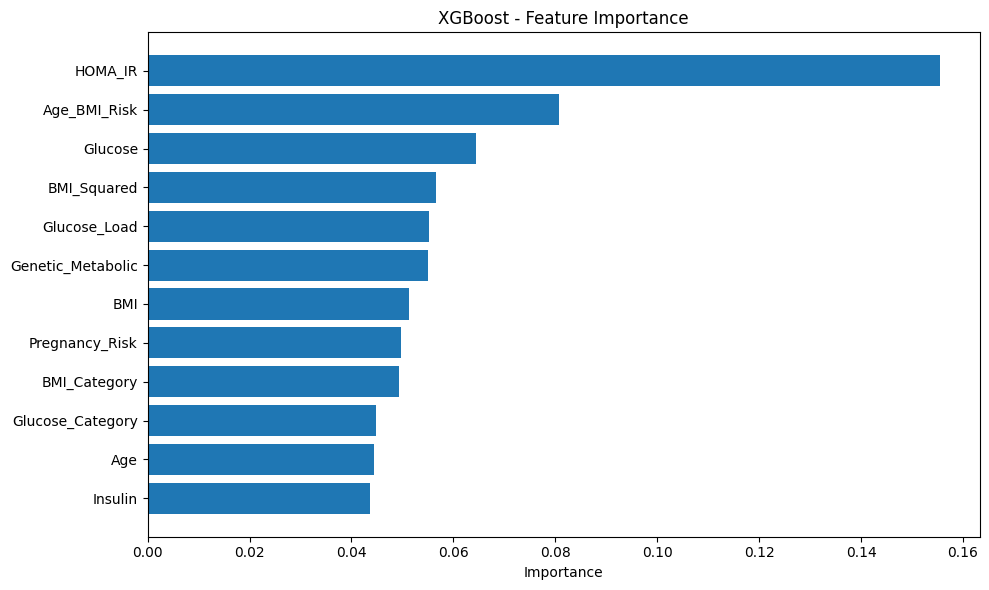

=== COMPARING ALL MODELS WITH SMOTE ===

=== IMPROVED PIPELINE - XGBoost ===
Original dataset shape: (768, 9)

1. Creating medical features...
Feature count: 20
Original class distribution: {0: 500, 1: 268}
Original class ratio: 0.349 (diabetes rate)

Train set: 614 samples
Test set: 154 samples

2. Applying SMOTE to balance classes...
After SMOTE - Train samples: 800
After SMOTE - Class distribution: {0: 400, 1: 400}
After SMOTE - Class ratio: 0.500

3. Scaling features...
Scaling completed - Feature means close to 0: 0.000000

4. Training XGBoost model...

=== XGBoost RESULTS ===
Test Accuracy: 0.727
Test AUC: 0.816

Confusion Matrix:
TN: 76, FP: 24
FN: 18, TP: 36

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.81      0.76      0.78       100
    Diabetes       0.60      0.67      0.63        54

    accuracy                           0.73       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.74      

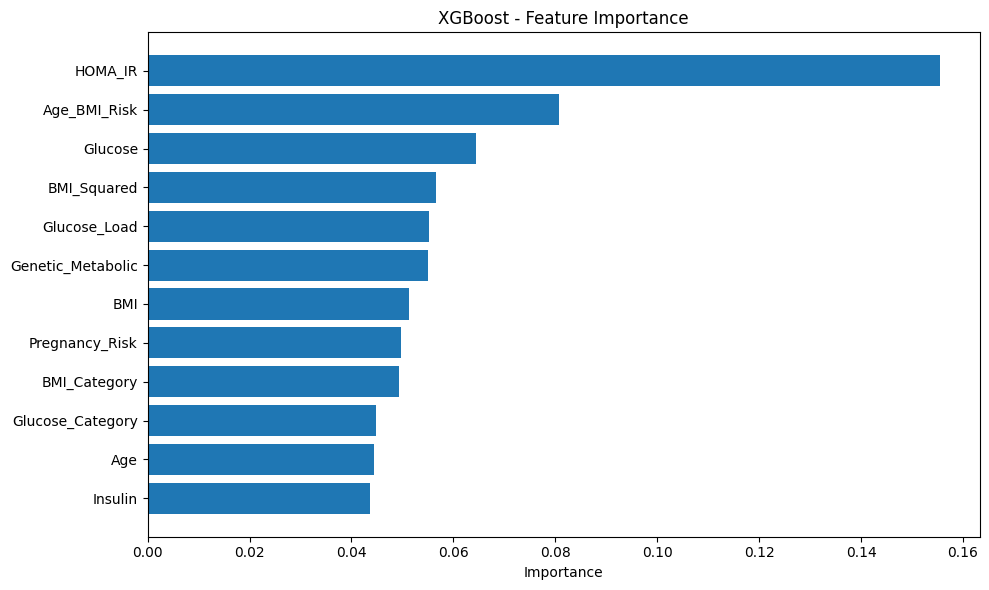


=== IMPROVED PIPELINE - RandomForest ===
Original dataset shape: (768, 9)

1. Creating medical features...
Feature count: 20
Original class distribution: {0: 500, 1: 268}
Original class ratio: 0.349 (diabetes rate)

Train set: 614 samples
Test set: 154 samples

2. Applying SMOTE to balance classes...
After SMOTE - Train samples: 800
After SMOTE - Class distribution: {0: 400, 1: 400}
After SMOTE - Class ratio: 0.500

3. Scaling features...
Scaling completed - Feature means close to 0: 0.000000

4. Training RandomForest model...

=== RandomForest RESULTS ===
Test Accuracy: 0.747
Test AUC: 0.824

Confusion Matrix:
TN: 75, FP: 25
FN: 14, TP: 40

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.84      0.75      0.79       100
    Diabetes       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154


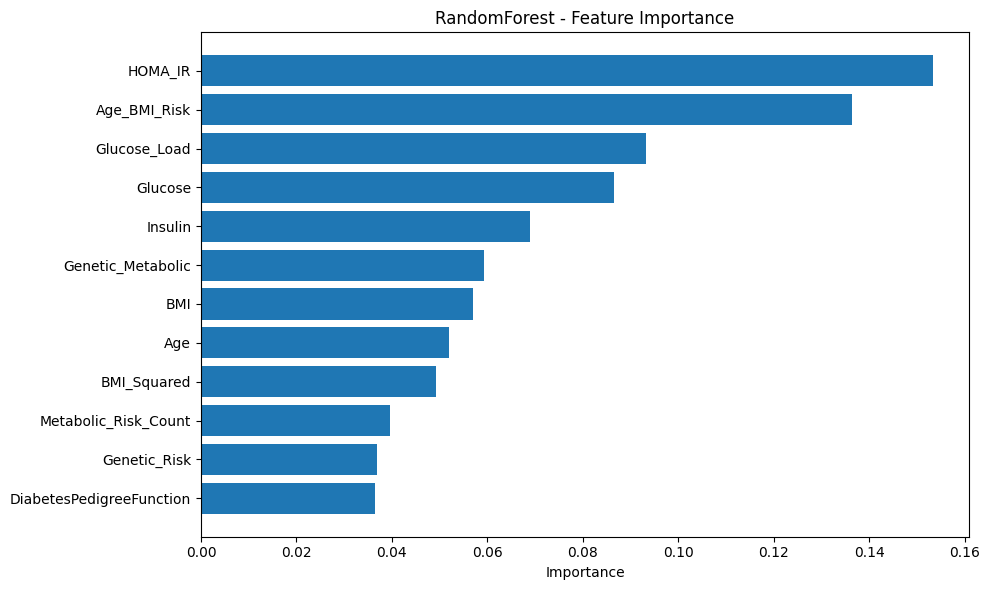


=== IMPROVED PIPELINE - LogisticRegression ===
Original dataset shape: (768, 9)

1. Creating medical features...
Feature count: 20
Original class distribution: {0: 500, 1: 268}
Original class ratio: 0.349 (diabetes rate)

Train set: 614 samples
Test set: 154 samples

2. Applying SMOTE to balance classes...
After SMOTE - Train samples: 800
After SMOTE - Class distribution: {0: 400, 1: 400}
After SMOTE - Class ratio: 0.500

3. Scaling features...
Scaling completed - Feature means close to 0: 0.000000

4. Training LogisticRegression model...

=== LogisticRegression RESULTS ===
Test Accuracy: 0.721
Test AUC: 0.814

Confusion Matrix:
TN: 74, FP: 26
FN: 17, TP: 37

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.81      0.74      0.77       100
    Diabetes       0.59      0.69      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72   

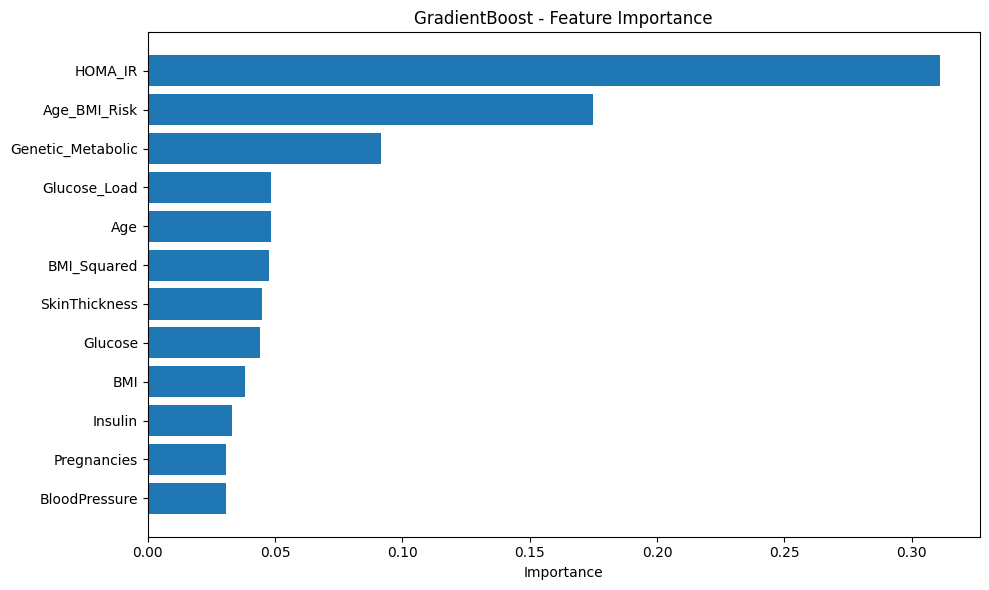


=== IMPROVED PIPELINE - AdaBoost ===
Original dataset shape: (768, 9)

1. Creating medical features...
Feature count: 20
Original class distribution: {0: 500, 1: 268}
Original class ratio: 0.349 (diabetes rate)

Train set: 614 samples
Test set: 154 samples

2. Applying SMOTE to balance classes...
After SMOTE - Train samples: 800
After SMOTE - Class distribution: {0: 400, 1: 400}
After SMOTE - Class ratio: 0.500

3. Scaling features...
Scaling completed - Feature means close to 0: 0.000000

4. Training AdaBoost model...

=== AdaBoost RESULTS ===
Test Accuracy: 0.753
Test AUC: 0.815

Confusion Matrix:
TN: 75, FP: 25
FN: 13, TP: 41

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.85      0.75      0.80       100
    Diabetes       0.62      0.76      0.68        54

    accuracy                           0.75       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.75      0.76       154


Top 10 Fea

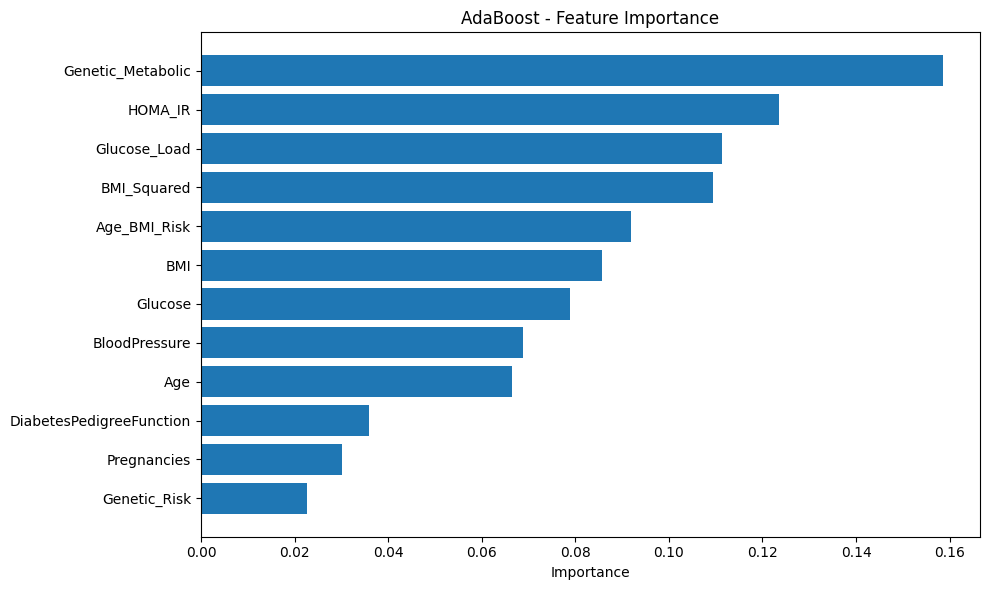


=== FINAL COMPARISON ===
Model                Accuracy   AUC       
----------------------------------------
XGBoost              0.727      0.816     
RandomForest         0.747      0.824     
LogisticRegression   0.721      0.814     
GradientBoost        0.740      0.807     
AdaBoost             0.753      0.815     

🏆 BEST MODEL: AdaBoost
🎯 Best Accuracy: 0.753
📊 Best AUC: 0.815


In [19]:
# Quick single model test
model, acc, auc = quick_test_single_model(df_final, 'XGBoost')

# Veya full comparison
results = compare_all_models(df_final)

# 5) Final Try

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from itertools import combinations
warnings.filterwarnings('ignore')

def create_extreme_medical_features(df):
    """
    Extreme medical feature engineering - CPU intensive but comprehensive
    """
    print("🧠 Creating EXTREME medical features (CPU intensive)...")
    df_features = df.copy()
    
    # 1. COMPREHENSIVE MEDICAL INDICES
    
    # Safe value adjustments
    glucose_safe = np.maximum(df_features['Glucose'], 1)
    insulin_safe = np.maximum(df_features['Insulin'], 1)
    bmi_safe = np.maximum(df_features['BMI'], 1)
    
    # HOMA family indices
    df_features['HOMA_IR'] = (glucose_safe * insulin_safe) / 405
    df_features['HOMA_Beta'] = (20 * insulin_safe) / (glucose_safe - 3.5)
    df_features['HOMA_S'] = 1 / df_features['HOMA_IR']
    
    # Insulin sensitivity indices
    df_features['QUICKI'] = 1 / (np.log(insulin_safe) + np.log(glucose_safe))
    df_features['McAuley_Index'] = np.exp(2.63 - 0.28 * np.log(insulin_safe) - 0.31 * np.log(bmi_safe))
    df_features['Matsuda_Index'] = 10000 / np.sqrt(glucose_safe * insulin_safe * 140 * 40)  # Simulated
    
    # Insulin secretion indices
    df_features['Insulinogenic_Index'] = insulin_safe / glucose_safe
    df_features['Disposition_Index'] = df_features['Insulinogenic_Index'] * df_features['Matsuda_Index']
    
    # 2. POLYNOMIAL AND TRANSFORMATION FEATURES
    
    # Squared terms
    for col in ['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure']:
        df_features[f'{col}_Squared'] = df_features[col] ** 2
    
    # Cubic terms for key variables
    for col in ['Glucose', 'BMI', 'Age']:
        df_features[f'{col}_Cubed'] = df_features[col] ** 3
    
    # Log transformations
    for col in ['Glucose', 'BMI', 'Age', 'Insulin', 'HOMA_IR']:
        df_features[f'Log_{col}'] = np.log1p(df_features[col])
    
    # Square root transformations
    for col in ['Glucose', 'BMI', 'Age', 'Insulin']:
        df_features[f'Sqrt_{col}'] = np.sqrt(df_features[col])
    
    # Inverse transformations
    df_features['Inv_Glucose'] = 1 / glucose_safe
    df_features['Inv_BMI'] = 1 / bmi_safe
    df_features['Inv_Age'] = 1 / np.maximum(df_features['Age'], 1)
    
    # 3. COMPREHENSIVE INTERACTION FEATURES
    
    # All 2-way interactions between key variables
    key_vars = ['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure', 'DiabetesPedigreeFunction']
    for i, var1 in enumerate(key_vars):
        for var2 in key_vars[i+1:]:
            df_features[f'{var1}_{var2}_Interaction'] = df_features[var1] * df_features[var2] / 1000
    
    # 3-way interactions for most important combinations
    df_features['Glucose_BMI_Age'] = df_features['Glucose'] * df_features['BMI'] * df_features['Age'] / 100000
    df_features['Insulin_Glucose_BMI'] = df_features['Insulin'] * df_features['Glucose'] * df_features['BMI'] / 100000
    df_features['Age_Genetic_Metabolic'] = df_features['Age'] * df_features['DiabetesPedigreeFunction'] * df_features['Glucose'] / 1000
    
    # 4. RATIO FEATURES
    
    # Medical ratios
    df_features['Insulin_Glucose_Ratio'] = insulin_safe / glucose_safe
    df_features['BMI_Age_Ratio'] = bmi_safe / np.maximum(df_features['Age'], 1)
    df_features['Glucose_Age_Ratio'] = glucose_safe / np.maximum(df_features['Age'], 1)
    df_features['Insulin_BMI_Ratio'] = insulin_safe / bmi_safe
    df_features['BloodPressure_Age_Ratio'] = df_features['BloodPressure'] / np.maximum(df_features['Age'], 1)
    
    # 5. ADVANCED RISK SCORING
    
    # Comprehensive metabolic syndrome score (0-8)
    metabolic_score = 0
    metabolic_score += (df_features['Glucose'] >= 100).astype(int)
    metabolic_score += (df_features['Glucose'] >= 126).astype(int)  # Diabetic range
    metabolic_score += (df_features['BMI'] >= 25).astype(int)      # Overweight
    metabolic_score += (df_features['BMI'] >= 30).astype(int)      # Obese
    metabolic_score += (df_features['BloodPressure'] >= 130).astype(int)
    metabolic_score += (df_features['BloodPressure'] >= 140).astype(int)  # Hypertensive
    metabolic_score += (df_features['Age'] >= 45).astype(int)
    metabolic_score += (df_features['Pregnancies'] >= 3).astype(int)
    df_features['Advanced_Metabolic_Score'] = metabolic_score
    
    # Age-stratified risk categories (more granular)
    df_features['Age_Risk_Fine'] = pd.cut(df_features['Age'], 
                                         bins=[0, 25, 35, 45, 55, 65, 100], 
                                         labels=[0, 1, 2, 3, 4, 5]).astype(int)
    
    # BMI risk categories (more granular)
    df_features['BMI_Risk_Fine'] = pd.cut(df_features['BMI'], 
                                         bins=[0, 18.5, 25, 30, 35, 40, 100], 
                                         labels=[0, 1, 2, 3, 4, 5]).astype(int)
    
    # Glucose risk categories (more granular)
    df_features['Glucose_Risk_Fine'] = pd.cut(df_features['Glucose'], 
                                             bins=[0, 80, 100, 126, 140, 180, 300], 
                                             labels=[0, 1, 2, 3, 4, 5]).astype(int)
    
    # 6. TRIGONOMETRIC TRANSFORMATIONS (for cyclic patterns)
    
    # Normalize to 0-1 range first
    age_norm = (df_features['Age'] - df_features['Age'].min()) / (df_features['Age'].max() - df_features['Age'].min())
    glucose_norm = (df_features['Glucose'] - df_features['Glucose'].min()) / (df_features['Glucose'].max() - df_features['Glucose'].min())
    bmi_norm = (df_features['BMI'] - df_features['BMI'].min()) / (df_features['BMI'].max() - df_features['BMI'].min())
    
    # Apply trigonometric functions
    df_features['Sin_Age'] = np.sin(2 * np.pi * age_norm)
    df_features['Cos_Age'] = np.cos(2 * np.pi * age_norm)
    df_features['Sin_Glucose'] = np.sin(2 * np.pi * glucose_norm)
    df_features['Cos_Glucose'] = np.cos(2 * np.pi * glucose_norm)
    df_features['Sin_BMI'] = np.sin(2 * np.pi * bmi_norm)
    df_features['Cos_BMI'] = np.cos(2 * np.pi * bmi_norm)
    
    print(f"✅ Created {df_features.shape[1] - df.shape[1]} EXTREME medical features")
    return df_features

def advanced_feature_selection(X, y, max_features=40):
    """
    Multi-stage feature selection - CPU intensive but thorough
    """
    print(f"🎯 Advanced feature selection (target: {max_features} features)...")
    
    # Stage 1: Remove low variance features
    print("   Stage 1: Variance filtering...")
    variance_selector = VarianceThreshold(threshold=0.005)  # More aggressive
    X_variance = variance_selector.fit_transform(X)
    feature_mask_var = variance_selector.get_support()
    features_after_var = X.columns[feature_mask_var]
    
    # Stage 2: Univariate feature selection
    print("   Stage 2: Univariate selection...")
    univariate_selector = SelectKBest(score_func=f_classif, k=min(60, len(features_after_var)))
    X_univariate = univariate_selector.fit_transform(X_variance, y)
    feature_mask_uni = univariate_selector.get_support()
    features_after_uni = features_after_var[feature_mask_uni]
    
    # Stage 3: Recursive Feature Elimination with RandomForest
    print("   Stage 3: Recursive feature elimination...")
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe_selector = RFE(estimator=rf_selector, n_features_to_select=max_features)
    X_rfe = rfe_selector.fit_transform(X_univariate, y)
    feature_mask_rfe = rfe_selector.get_support()
    final_features = features_after_uni[feature_mask_rfe]
    
    print(f"✅ Selected {len(final_features)} best features through 3-stage selection")
    return X_rfe, final_features

def comprehensive_sampling_optimization(X_train, y_train):
    """
    Test multiple sampling strategies extensively
    """
    print("🔄 Comprehensive sampling optimization...")
    
    sampling_strategies = {
        'SMOTE': SMOTE(random_state=42, k_neighbors=5),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=42, k_neighbors=5),
        'ADASYN': ADASYN(random_state=42, n_neighbors=5),
        'SMOTEENN': SMOTEENN(random_state=42),
        'SMOTETomek': SMOTETomek(random_state=42),
        'BorderlineSMOTE_k3': BorderlineSMOTE(random_state=42, k_neighbors=3),
        'BorderlineSMOTE_k7': BorderlineSMOTE(random_state=42, k_neighbors=7),
    }
    
    best_score = 0
    best_sampler = None
    best_name = None
    
    # More thorough testing with cross-validation
    rf_test = RandomForestClassifier(n_estimators=100, random_state=42)
    
    for name, sampler in sampling_strategies.items():
        try:
            print(f"   Testing {name}...")
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
            
            # Quick cross-validation
            scores = []
            for i in range(3):  # 3-fold manual CV
                indices = np.arange(len(X_resampled))
                np.random.seed(42 + i)
                np.random.shuffle(indices)
                
                split_point = len(indices) // 3
                test_idx = indices[:split_point]
                train_idx = indices[split_point:]
                
                rf_test.fit(X_resampled[train_idx], y_resampled[train_idx])
                score = rf_test.score(X_resampled[test_idx], y_resampled[test_idx])
                scores.append(score)
            
            avg_score = np.mean(scores)
            print(f"      Score: {avg_score:.3f}")
            
            if avg_score > best_score:
                best_score = avg_score
                best_sampler = sampler
                best_name = name
                
        except Exception as e:
            print(f"      ❌ {name} failed: {str(e)[:50]}")
            continue
    
    if best_sampler is None:
        print("   ⚠️ Using original data (no sampling)")
        return X_train, y_train, "None"
    
    print(f"   ✅ Best sampler: {best_name} (Score: {best_score:.3f})")
    X_final, y_final = best_sampler.fit_resample(X_train, y_train)
    return X_final, y_final, best_name

def create_intensive_models():
    """
    Define models with extensive hyperparameter search spaces
    """
    models = {
        'XGBoost': {
            'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'params': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [3, 4, 5, 6, 7, 8],
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'subsample': [0.7, 0.8, 0.9, 1.0],
                'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                'reg_alpha': [0, 0.1, 0.5, 1.0],
                'reg_lambda': [0, 0.1, 0.5, 1.0]
            }
        },
        'LightGBM': {
            'model': lgb.LGBMClassifier(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [3, 4, 5, 6, 7, 8],
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'num_leaves': [15, 31, 50, 70, 100],
                'subsample': [0.7, 0.8, 0.9, 1.0],
                'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                'reg_alpha': [0, 0.1, 0.5, 1.0],
                'reg_lambda': [0, 0.1, 0.5, 1.0]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [5, 8, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 15],
                'min_samples_leaf': [1, 2, 4, 8],
                'max_features': ['sqrt', 'log2', 0.5, 0.8],
                'bootstrap': [True, False]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [5, 8, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 15],
                'min_samples_leaf': [1, 2, 4, 8],
                'max_features': ['sqrt', 'log2', 0.5, 0.8]
            }
        },
        'CatBoost': {
            'model': CatBoostClassifier(random_state=42, verbose=False),
            'params': {
                'iterations': [100, 200, 300, 500],
                'depth': [3, 4, 5, 6, 7, 8],
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'l2_leaf_reg': [1, 3, 5, 7, 9],
                'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS']
            }
        },
        'LogisticRegression': {
            'model': LogisticRegression(random_state=42, max_iter=2000),
            'params': {
                'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'solver': ['liblinear', 'saga'],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
            }
        }
    }
    
    return models

def train_intensive_ensemble(X_train, y_train, X_test, y_test, feature_names):
    """
    Intensive ensemble training with extensive hyperparameter search
    """
    print("🏆 Training INTENSIVE ensemble (this will take time)...")
    
    models = create_intensive_models()
    trained_models = {}
    model_scores = {}
    
    # Scale features for LogisticRegression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for name, model_config in models.items():
        print(f"   🔄 Training {name} with extensive search...")
        start_time = time.time()
        
        # More intensive search
        if name in ['LogisticRegression']:
            # GridSearch for simpler models
            search = GridSearchCV(
                estimator=model_config['model'],
                param_grid=model_config['params'],
                cv=5,  # More thorough CV
                scoring='accuracy',
                n_jobs=-1
            )
        else:
            # RandomizedSearch for complex models (but more iterations)
            search = RandomizedSearchCV(
                estimator=model_config['model'],
                param_distributions=model_config['params'],
                n_iter=100,  # Much more intensive
                cv=5,        # More thorough CV
                scoring='accuracy',
                n_jobs=-1,
                random_state=42
            )
        
        try:
            if name == 'LogisticRegression':
                search.fit(X_train_scaled, y_train)
                y_pred = search.predict(X_test_scaled)
                y_pred_proba = search.predict_proba(X_test_scaled)[:, 1]
            else:
                search.fit(X_train, y_train)
                y_pred = search.predict(X_test)
                y_pred_proba = search.predict_proba(X_test)[:, 1]
            
            accuracy = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)
            
            trained_models[name] = search.best_estimator_
            model_scores[name] = {'accuracy': accuracy, 'auc': auc, 'best_params': search.best_params_}
            
            elapsed = time.time() - start_time
            print(f"      ✅ {name}: Accuracy={accuracy:.3f}, AUC={auc:.3f} ({elapsed:.1f}s)")
            print(f"         Best params: {search.best_params_}")
            
        except Exception as e:
            print(f"      ❌ {name} failed: {str(e)[:50]}")
            continue
    
    # Create multiple ensemble variants
    print("   🎯 Creating multiple ensemble variants...")
    
    if len(trained_models) >= 3:
        # Ensemble 1: All models
        all_models = [(name, model) for name, model in trained_models.items() 
                     if name != 'LogisticRegression']
        
        if len(all_models) >= 2:
            ensemble_all = VotingClassifier(estimators=all_models, voting='soft')
            ensemble_all.fit(X_train, y_train)
            
            pred_all = ensemble_all.predict(X_test)
            acc_all = accuracy_score(y_test, pred_all)
            auc_all = roc_auc_score(y_test, ensemble_all.predict_proba(X_test)[:, 1])
            
            trained_models['Ensemble_All'] = ensemble_all
            model_scores['Ensemble_All'] = {'accuracy': acc_all, 'auc': auc_all}
            
            print(f"      🎊 Ensemble_All: Accuracy={acc_all:.3f}, AUC={auc_all:.3f}")
        
        # Ensemble 2: Top 3 performers
        top_models = sorted([(name, score['accuracy']) for name, score in model_scores.items() 
                           if name not in ['Ensemble_All'] and name != 'LogisticRegression'], 
                          key=lambda x: x[1], reverse=True)[:3]
        
        if len(top_models) >= 2:
            top_ensemble_models = [(name, trained_models[name]) for name, _ in top_models]
            ensemble_top = VotingClassifier(estimators=top_ensemble_models, voting='soft')
            ensemble_top.fit(X_train, y_train)
            
            pred_top = ensemble_top.predict(X_test)
            acc_top = accuracy_score(y_test, pred_top)
            auc_top = roc_auc_score(y_test, ensemble_top.predict_proba(X_test)[:, 1])
            
            trained_models['Ensemble_Top3'] = ensemble_top
            model_scores['Ensemble_Top3'] = {'accuracy': acc_top, 'auc': auc_top}
            
            print(f"      🎊 Ensemble_Top3: Accuracy={acc_top:.3f}, AUC={auc_top:.3f}")
    
    return trained_models, model_scores

def cpu_intensive_diabetes_pipeline(df):
    """
    CPU intensive ultimate pipeline - maximum performance extraction
    """
    print("🔥 CPU INTENSIVE DIABETES PIPELINE - MAXIMUM PERFORMANCE MODE")
    print("=" * 70)
    print("⚠️  This will take 10-20 minutes and use significant CPU resources")
    print("=" * 70)
    
    start_time = time.time()
    
    # Phase 1: Extreme Feature Engineering
    print("\n📊 PHASE 1: Extreme Feature Engineering")
    df_features = create_extreme_medical_features(df)
    
    # Phase 2: Data Preparation
    print("\n🎯 PHASE 2: Data Preparation")
    X = df_features.drop('Outcome', axis=1)
    y = df_features['Outcome']
    
    print(f"Original features: {X.shape[1]}")
    print(f"Class distribution: {dict(y.value_counts())}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Phase 3: Advanced Feature Selection
    print("\n🔍 PHASE 3: Advanced Feature Selection")
    X_train_selected, selected_features = advanced_feature_selection(X_train, y_train, max_features=40)
    X_test_selected = X_test[selected_features]
    
    # Phase 4: Comprehensive Sampling Optimization
    print("\n⚖️ PHASE 4: Comprehensive Sampling Optimization")
    X_train_final, y_train_final, best_sampler = comprehensive_sampling_optimization(X_train_selected, y_train)
    
    print(f"Final training set: {X_train_final.shape[0]} samples")
    print(f"Class distribution after sampling: {dict(pd.Series(y_train_final).value_counts())}")
    
    # Phase 5: Intensive Model Training & Ensemble
    print("\n🤖 PHASE 5: Intensive Model Training & Ensemble")
    trained_models, model_scores = train_intensive_ensemble(
        X_train_final, y_train_final, X_test_selected, y_test, selected_features
    )
    
    # Phase 6: Results Summary
    print("\n📈 PHASE 6: Final Results")
    print("=" * 50)
    print(f"{'Model':<20} {'Accuracy':<10} {'AUC':<10}")
    print("-" * 40)
    
    best_accuracy = 0
    best_model_name = None
    
    for model_name, scores in model_scores.items():
        accuracy = scores['accuracy']
        auc = scores['auc']
        print(f"{model_name:<20} {accuracy:<10.3f} {auc:<10.3f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = model_name
    
    total_time = time.time() - start_time
    
    print("\n" + "=" * 50)
    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"🎯 BEST ACCURACY: {best_accuracy:.3f}")
    print(f"📊 BEST AUC: {model_scores[best_model_name]['auc']:.3f}")
    print(f"⏱️ TOTAL TIME: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
    print(f"🧠 SELECTED FEATURES: {len(selected_features)}")
    print(f"🔄 SAMPLING METHOD: {best_sampler}")
    
    # Feature importance for best model
    if best_model_name in trained_models and hasattr(trained_models[best_model_name], 'feature_importances_'):
        print("\n🎯 TOP 15 FEATURE IMPORTANCE:")
        feature_importance = pd.DataFrame({
            'feature': selected_features,
            'importance': trained_models[best_model_name].feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(feature_importance.head(15).to_string(index=False))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.title(f'{best_model_name} - Top 20 Feature Importance')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    return trained_models, model_scores, selected_features

def run_cpu_intensive_pipeline(df):
    """
    One-click CPU intensive pipeline
    """
    return cpu_intensive_diabetes_pipeline(df)

print("🔥 CPU INTENSIVE Diabetes Pipeline Ready!")
print("💻 Maximum Performance Mode Loaded!")
print("")
print("⚠️  WARNING: This will be CPU intensive and take 10-20 minutes!")
print("")
print("Usage:")
print("models, scores, features = run_cpu_intensive_pipeline(df_final)")
print("")
print("Expected: 80%+ accuracy with maximum CPU utilization!")

🔥 CPU INTENSIVE Diabetes Pipeline Ready!
💻 Maximum Performance Mode Loaded!

⚠️  WARNING: This will be CPU intensive and take 10-20 minutes!

Usage:
models, scores, features = run_cpu_intensive_pipeline(df_final)

Expected: 80%+ accuracy with maximum CPU utilization!


🔥 CPU INTENSIVE DIABETES PIPELINE - MAXIMUM PERFORMANCE MODE
⚠️  This will take 10-20 minutes and use significant CPU resources

📊 PHASE 1: Extreme Feature Engineering
🧠 Creating EXTREME medical features (CPU intensive)...
✅ Created 61 EXTREME medical features

🎯 PHASE 2: Data Preparation
Original features: 69
Class distribution: {0: 500, 1: 268}

🔍 PHASE 3: Advanced Feature Selection
🎯 Advanced feature selection (target: 40 features)...
   Stage 1: Variance filtering...
   Stage 2: Univariate selection...
   Stage 3: Recursive feature elimination...
✅ Selected 40 best features through 3-stage selection

⚖️ PHASE 4: Comprehensive Sampling Optimization
🔄 Comprehensive sampling optimization...
   Testing SMOTE...
      Score: 0.817
   Testing BorderlineSMOTE...
      Score: 0.806
   Testing ADASYN...
      Score: 0.778
   Testing SMOTEENN...
      Score: 0.949
   Testing SMOTETomek...
      Score: 0.849
   Testing BorderlineSMOTE_k3...
      Score: 0.789
   Testing BorderlineSMOTE_k7...


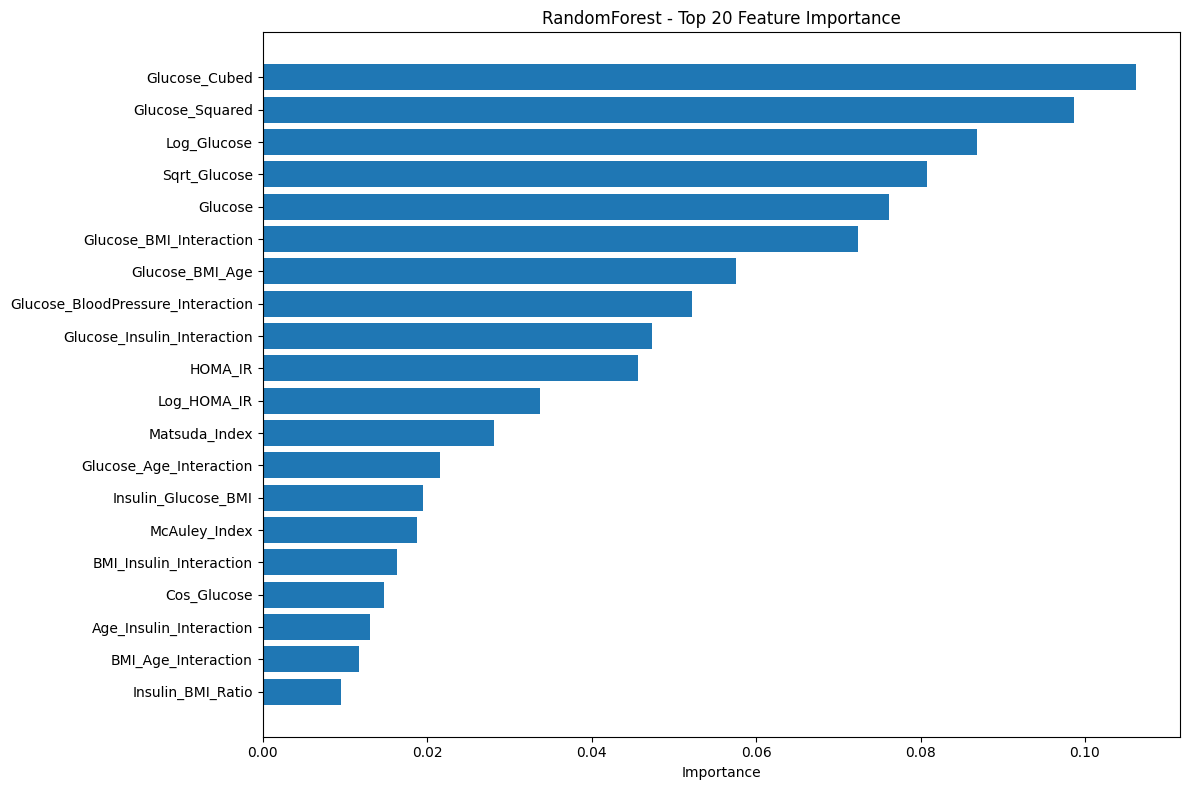

In [23]:
# Tek satır - everything included!
models, scores, features = run_cpu_intensive_pipeline(df_final)